In [16]:
# IMPORTS
import copy
import glob
from imdb import IMDb
from itertools import cycle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import nltk
import numpy as np
import random
import statistics
import subprocess
import textclean
import unicodedata

from __future__ import print_function
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from nltk.stem import PorterStemmer
from scipy.stats import binom
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import AffinityPropagation
from textclean import textclean
from nltk.tokenize import TweetTokenizer

# nltk.download('punkt')
nltk.download('tagsets')


[nltk_data] Downloading package tagsets to /home/karen/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [2]:
# CONSTANTS
NUM_FOLDS = 10
ACL_PATH = "aclImdb_v1/aclImdb/{}"
ACL_FOLDER_PATHS = [
    ACL_PATH.format("train/unsup/*"),
    ACL_PATH.format("train/pos/*"),
    ACL_PATH.format("train/neg/*"),
    ACL_PATH.format("test/pos/*"),
    ACL_PATH.format("test/neg/*")
]
ACL_URL_PATHS = [
    ACL_PATH.format("train/urls_unsup.txt"),
    ACL_PATH.format("train/urls_pos.txt"),
    ACL_PATH.format("train/urls_neg.txt"),
    ACL_PATH.format("test/urls_pos.txt"),
    ACL_PATH.format("test/urls_neg.txt")
]
PANG_POS_PATH = "POS-tokenized/POS/*"
PANG_NEG_PATH = "NEG-tokenized/NEG/*"
SEED = 0
NUM_FOLDS = 10
POS = 1
NEG = -1
R = 5000

### Functions

#### Fetch Data

In [110]:
def get_embeddings_training_set(folder_paths_list, url_paths_list):
    """Get all embeddings docs from folder_path_list"""
    all_docs = []
    for folder_path, url_path in zip(folder_paths_list, url_paths_list):
        folder_documents = _get_docs_from_folder(
            folder_path, url_path, pretokenised=False)
        all_docs.extend(folder_documents)
    return all_docs

def _get_docs_from_folder(folder_path, url_file_name=None, pretokenised=False):
    if url_file_name != None:
        move_id_dict = _get_movie_number_to_movie_id(url_file_name)
    files = glob.glob(folder_path)
    folder_documents = []
    tknzr = TweetTokenizer()
    for file_name in files:
        with open(file_name) as fp:
            doc_words = []
            if pretokenised:
                doc_words = [word.strip("\n") 
                             for word in fp.readlines()
                             if word]
            else:
                document = fp.read()
                doc_words = filter(None, tknzr.tokenize(document))
            
            if url_file_name == None:
                folder_documents.append(doc_words)
            else:
                movie_number = int(file_name.split("/")[-1].split("_")[0])
                folder_documents.append(
                    (move_id_dict[movie_number], doc_words))
                
    return folder_documents

def _get_movie_number_to_movie_id(url_file_name):
    movie_id_dict = {}
    with open(url_file_name) as fp:
        for index, line in enumerate(fp.readlines()):
            # Each line is expected to be a url such as:
            # http://www.imdb.com/title/tt0018515/usercomments
            movie_id = line.split("/")[4].lstrip("t")
            movie_id_dict[index] = movie_id
    return movie_id_dict

In [111]:
def write_embeddings_training_set_pos_tag(folder_paths_list):
    """Finds tags for each word in doc. Writes to disk. Returns it."""
    all_docs = []
    for folder_path in folder_paths_list:
        folder_documents = _write_pos_tag_for_folder(folder_path)
        all_docs.extend(folder_documents)
        return all_docs

def _write_pos_tag_for_folder(folder_path):
    files = glob.glob(folder_path)
    folder_documents = []
    tknzr = TweetTokenizer()
    for file_name in files: 
        with open(file_name) as fp:
            with open("tagged/{}_tagged.txt".format(
                file_name.split(".")[0]), "w+") as tag_fp:
                document = fp.read()
                doc_words = filter(None, tknzr.tokenize(document))
                tagged_doc_list = nltk.pos_tag(doc_words)
                to_print = "\n".join(["{}zzzz{}".format(word.encode('utf-8'), word_type.encode('utf-8'))
                            for (word,word_type) in tagged_doc_list])
                tag_fp.write(to_print)
                folder_documents.append(tagged_doc_list)
    return folder_documents

#### Visualisation

In [167]:
# TODO: Find clustering index between two neighbours.
def find_average_angle_and_distance(labelled_documents, doc2vec_model):
    all_angles = dict()
    all_angles["noun"] = []
    all_angles["verb"] = []
    all_angles["adjective"] = []
    all_angles["adverb"] = []
    all_angles["determiner"] = []
    all_angles["preposition"] = []
    all_angles["other"] = []
    all_distances = dict()
    all_distances["noun"] = []
    all_distances["verb"] = []
    all_distances["adjective"] = []
    all_distances["adverb"] = []
    all_distances["determiner"] = []
    all_distances["preposition"] = []
    all_distances["other"] = []
    
    neighbour_dist = dict()
    neighbour_dist["noun"] = []
    neighbour_dist["verb"] = []
    neighbour_dist["adjective"] = []
    neighbour_dist["adverb"] = []
    neighbour_dist["determiner"] = []
    neighbour_dist["preposition"] = []
    neighbour_dist["other"] = []
    for labelled_document in labelled_documents:
        # Find word vectors
        words = []
        tags = []
        word_vectors = []
        plotted_vectors = set()
        for word, tag in labelled_document:
            if word not in plotted_vectors:
                try:
                    vector = doc2vec_model.wv.get_vector(word)
                    words.append("{} : {}".format(word, tag))
                    word_vectors.append(vector)
                    tags.append(tag)
                    plotted_vectors.add(word)
                except:
                    pass

        # Find document vector
        doc_words = [word for (word, label) in labelled_docs[0]]
        doc_vector = doc2vec_model.infer_vector(doc_words)
        words.append("DOCUMENT")
        word_vectors.append(doc_vector)
        tags.append("k")

        # Get mean distance between word types and doc vector
        # TODO: take into account repetitions
        colours, categories = colour_code_and_categories(word_vectors, tags)
        for tag, vectors in categories.items():
            for vector in vectors:
                all_angles[tag].append(math.degrees(angle_between(doc_vector, vector)))
                euc_dist = np.linalg.norm(vector-doc_vector)
                all_distances[tag].append(euc_dist)
                
                #calc stochastic neighbour prob
#                 num = math.exp(- (euc_dist ** 2))
#                 denom = -1 #substract exp(0) for the case when k = i.
#                 for vector_j in categories.values():
#                     euc_dist_j = np.linalg.norm(vector-vector_j)
#                     denom += math.exp(-(euc_dist_j **2))
#                 neighbour_dist[tag].append(num/float(denom))

    for tag, vectors in categories.items():
        mean_angle = sum(all_angles[tag])/len(all_angles[tag])
        mean_dist = sum(all_distances[tag])/len(all_distances[tag])
        mean_negh_dist = 0# sum(neighbour_dist[tag])/len(neighbour_dist[tag])
        print("{}:\n Angle = {}; Distance = {}; TSNE = {}".format(tag, mean_angle, mean_dist, mean_negh_dist))

find_average_angle_and_distance(labelled_docs, doc2vec_model)

noun:
 Angle = 78.6132464771; Distance = 3.67015612429; TSNE = 0
determiner:
 Angle = 74.5335837214; Distance = 3.35457624759; TSNE = 0
adverb:
 Angle = 76.0418498489; Distance = 3.41428929404; TSNE = 0
adjective:
 Angle = 78.2848929917; Distance = 3.5851122987; TSNE = 0
preposition:
 Angle = 76.2325197441; Distance = 3.40282719381; TSNE = 0
verb:
 Angle = 76.9864500772; Distance = 3.54491438082; TSNE = 0
other:
 Angle = 71.3991272206; Distance = 3.1721727774; TSNE = 0


In [184]:
def plot_words_in_document(labelled_document, doc2vec_model, perplexity=5):
    # Find word vectors
    words = []
    tags = []
    word_vectors = []
    plotted_vectors = set()
    for word, tag in labelled_document:
        if word not in plotted_vectors:
            try:
                vector = doc2vec_model.wv.get_vector(word)
                words.append("{} : {}".format(word, tag))
                word_vectors.append(vector)
                tags.append(tag)
                plotted_vectors.add(word)
            except:
                pass
    
    # Find document vector
    doc_words = [word for (word, label) in labelled_docs[0]]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    words.append("DOCUMENT")
    word_vectors.append(doc_vector)
    tags.append("k")
    
    # Get mean distance between word types and doc vector
    # TODO: take into account repetitions
    colours, categories = colour_code_and_categories(word_vectors, tags)
    print("\nDISTANCES:")
    for tag, vectors in categories.items():
        mean_dist = min_distance_to_document_vector(doc_vector, vectors)
        print("{}: {} ".format(tag, mean_dist))
    
    print("\nANGLES:")
    for tag, vectors in categories.items():
        mean_angle = math.degrees(min_angle_to_document_vector(doc_vector, vectors))
        print("{}: {} ".format(tag, mean_angle))
        
        
    reduced_vectors = TSNE(n_components=2, perplexity=perplexity).fit_transform(word_vectors)
    
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    xs = [vector[0] for vector in reduced_vectors]
    ys = [vector[1] for vector in reduced_vectors]
    ax.scatter(xs, ys, c=colours)
    for x, y, label in zip(xs, ys, words):
        ax.annotate(label, (x, y))
    plt.show()
    
def print_distances_and_angles(labelled_document, doc2vec_model, perplexity=5):
    # Find word vectors
    words = []
    tags = []
    word_vectors = []
    plotted_vectors = set()
    for word, tag in labelled_document:
        if word not in plotted_vectors:
            try:
                vector = doc2vec_model.wv.get_vector(word)
                words.append("{} : {}".format(word, tag))
                word_vectors.append(vector)
                tags.append(tag)
                plotted_vectors.add(word)
            except:
                pass
    
    # Find document vector
    doc_words = [word for (word, label) in labelled_docs[0]]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    words.append("DOCUMENT")
    word_vectors.append(doc_vector)
    tags.append("k")
    
    # Get mean distance between word types and doc vector
    # TODO: take into account repetitions
    colours, categories = colour_code_and_categories(word_vectors, tags)
    print("\nDISTANCES:")
    for tag, vectors in categories.items():
        mean_dist = min_distance_to_document_vector(doc_vector, vectors)
        print("{}: {} ".format(tag, mean_dist))
    
    print("\nANGLES:")
    for tag, vectors in categories.items():
        mean_angle = math.degrees(min_angle_to_document_vector(doc_vector, vectors))
        print("{}: {} ".format(tag, mean_angle))
    return 


In [187]:
for i in range(10):
    print_distances_and_angles(labelled_docs[i], doc2vec_model)



DISTANCES:
noun: 3.04332518578 
determiner: 3.20224666595 
adverb: 3.07611298561 
adjective: 3.10823225975 
preposition: 3.13048267365 
verb: 2.95780444145 
other: 0.0 

ANGLES:
noun: 62.2944329666 
determiner: 69.0472634141 
adverb: 62.4706723377 
adjective: 64.7415326519 
preposition: 66.618045164 
verb: 58.5903462476 
other: 0.0 

DISTANCES:
noun: 3.03325462341 
determiner: 3.15061378479 
adverb: 3.17927336693 
adjective: 2.97984790802 
preposition: 3.24682497978 
verb: 3.14832305908 
other: 0.0 

ANGLES:
noun: 63.9566004822 
determiner: 69.9398257046 
adverb: 71.1862191149 
adjective: 61.6477848069 
preposition: 74.3079502449 
verb: 64.6490382301 
other: 0.0 

DISTANCES:
noun: 2.92633080482 
determiner: 3.15331363678 
adverb: 3.17973065376 
adjective: 3.18801522255 
preposition: 3.11855959892 
verb: 3.00951647758 
other: 0.0 

ANGLES:
noun: 60.5619759742 
determiner: 69.4164556293 
adverb: 70.8787581494 
adjective: 70.1608028148 
preposition: 67.8150904576 
verb: 62.8303637598 
ot


DISTANCES:
noun: 3.34268443108 
determiner: 3.37385573387 
adverb: 3.34715297222 
adjective: 3.30262123214 
preposition: 3.36562697093 
verb: 3.37060881578 
other: 2.90012652533 

ANGLES:
noun: 69.775493812 
determiner: 73.2030947466 
adverb: 72.7293296032 
adjective: 69.788338939 
preposition: 73.6509460006 
verb: 70.5834691064 
other: 63.5234230549 


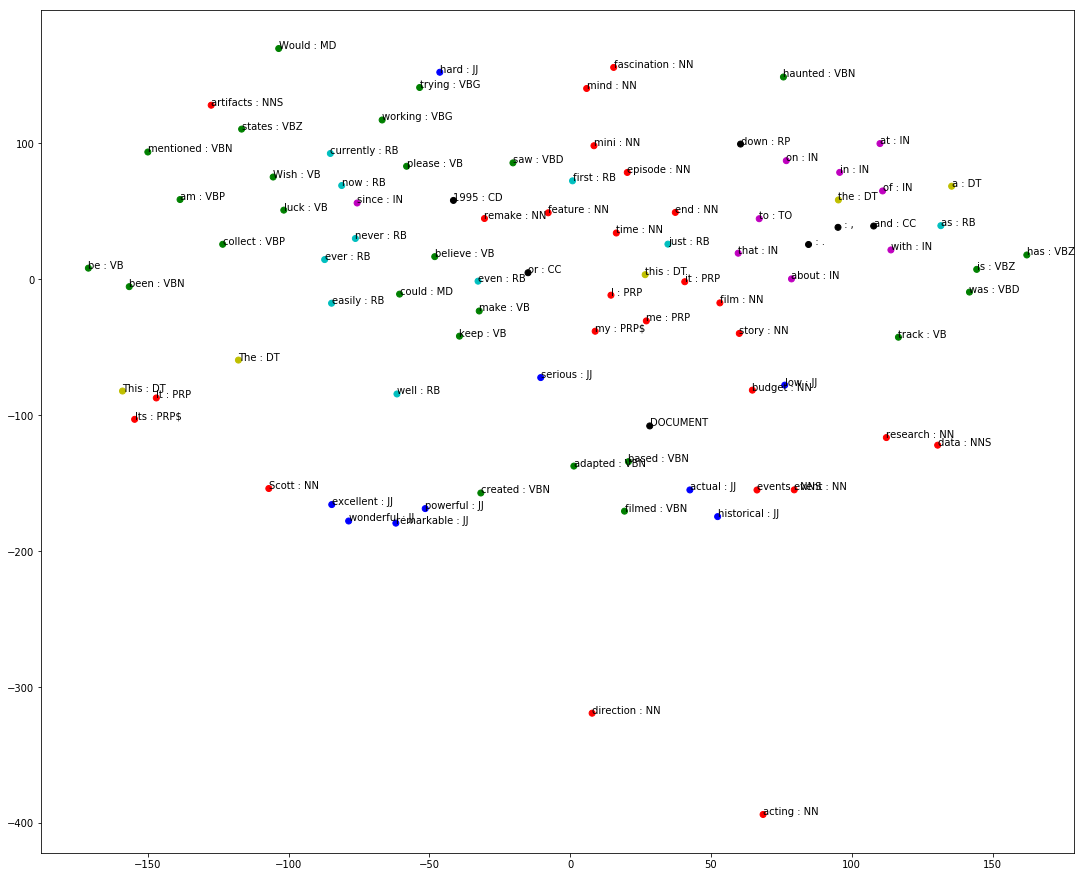

In [140]:
plot_words_in_document(labelled_docs[0], doc2vec_model)


DISTANCES:
noun: 3.62460598946 
determiner: 3.2732000351 
adverb: 3.37460807959 
adjective: 3.55811408588 
preposition: 3.42313985825 
verb: 3.52766773701 
other: 3.08116557863 

ANGLES:
noun: 77.5152329093 
determiner: 72.0230415977 
adverb: 75.6454720391 
adjective: 78.1655561986 
preposition: 77.0588116652 
verb: 74.69631002 
other: 68.7295809258 


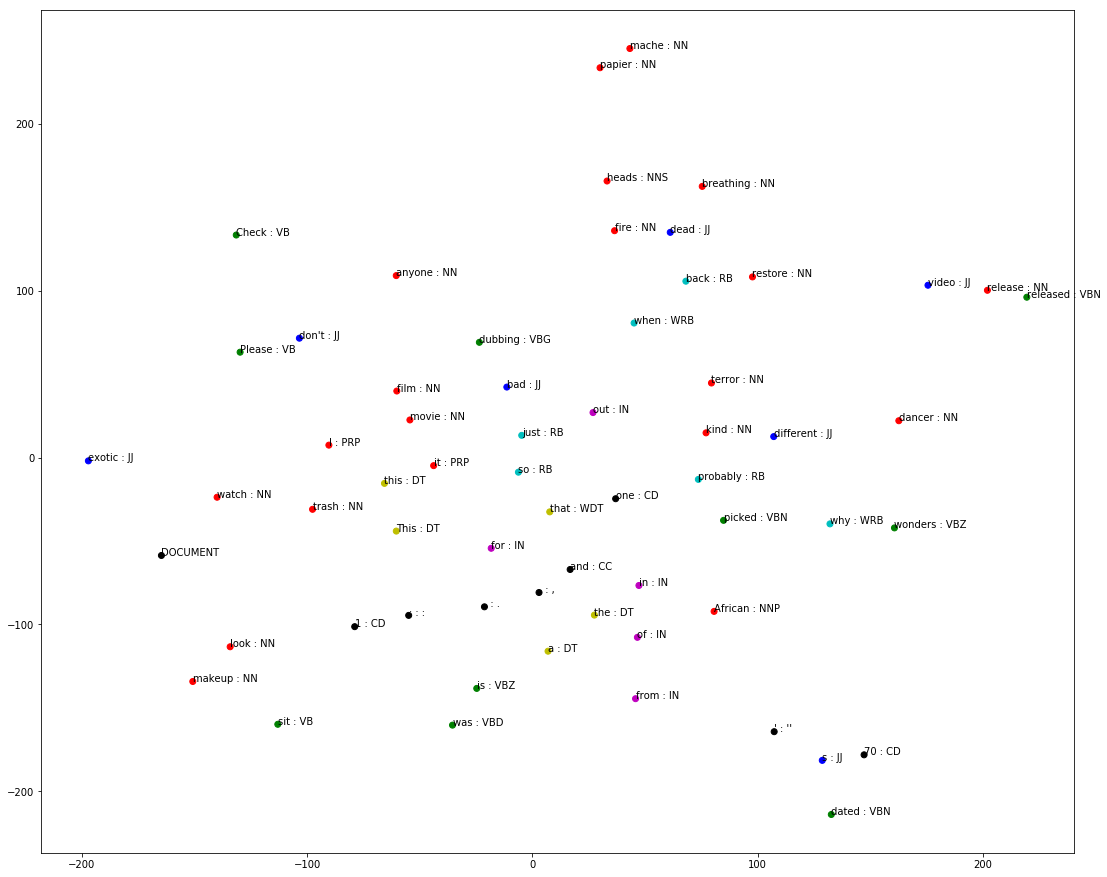

In [146]:
plot_words_in_document(labelled_docs[1], doc2vec_model, perplexity=9)

In [178]:
def find_closest_points(x, points, num_points=5):
    distances = [(np.linalg.norm(x-point_vec), word, tag)
                 for word, point_vec, tag in points]
    distances.sort()
    return distances[:5]

def find_closest_points_document(labelled_doc):
    # Find word vectors
    words = []
    for word, tag in set(doc):
        try:
            vector = doc2vec_model.wv.get_vector(word)
            words.append((word, vector, tag))
        except:
            pass
    
    # Find doc vector
    doc_words = [actual_word for actual_word, tag in doc]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    
    closest_points = find_closest_points(doc_vector, words)
    print(closest_points)

for i, doc in enumerate(labelled_docs[:50]):
    print(i)
    find_closest_points_document(doc)   
    print("")

0
[(2.941957, u'story', 'NN'), (2.96324, u'based', 'VBN'), (3.0117836, u'currently', 'RB'), (3.0177605, u'been', 'VBN'), (3.028446, u'mini', 'NN')]

1
[(2.3584323, u'trash', 'NN'), (2.4346097, u's', 'JJ'), (2.4777966, u'video', 'JJ'), (2.48689, u'70', 'CD'), (2.512069, u'look', 'NN')]

2
[(3.239333, u'moving', 'JJ'), (3.2653842, u'never', 'RB'), (3.2868237, u'Kill', 'NNP'), (3.3127646, u'real', 'JJ'), (3.3149204, u'book', 'NN')]

3
[(3.2936924, u'such', 'JJ'), (3.3628159, u'writer', 'NN'), (3.3804193, u'art', 'NN'), (3.4095514, u'budget', 'NN'), (3.4271631, u'product', 'NN')]

4
[(3.3207753, u'bored', 'VBN'), (3.4092255, u'Ireland', 'NNP'), (3.4268963, u'the', 'DT'), (3.484089, u'of', 'IN'), (3.48672, u'me', 'PRP')]

5
[(3.6357458, u'Powell', 'NNP'), (3.639285, u'Kay', 'NNP'), (3.6595628, u'Loy', 'NNP'), (3.732897, u'Carey', 'NNP'), (3.7536101, u'Myrna', 'NNP')]

6
[(2.9973898, u'turning', 'VBG'), (3.070656, u'down', 'RB'), (3.0844896, u'in', 'IN'), (3.08489, u'into', 'IN'), (3.1012905

In [114]:
def colour_code_and_categories(vectors, tags):
    categories = dict()
    categories["noun"] = []
    categories["verb"] = []
    categories["adjective"] = []
    categories["adverb"] = []
    categories["determiner"] = []
    categories["preposition"] = []
    categories["other"] = []
    
    colours = []
    for vector, tag in zip(vectors, tags):
        if tag.startswith("NN") or tag.startswith("PRP") or tag.startswith("WP"):
            # NOUN
            colours.append("r")
            categories["noun"].append(vector)
        elif tag.startswith("VB") or tag.startswith("MD"):
            # VERB
            colours.append("g")
            categories["verb"].append(vector)
        elif tag.startswith("JJ"):
            # ADJECTIVE
            colours.append("b")
            categories["adjective"].append(vector)
        elif tag.startswith("RB") or tag.startswith("WRB"):
            # ADVERB
            colours.append("c") 
            categories["adverb"].append(vector)
        elif tag.startswith("DT") or tag.startswith("EX") or tag.startswith("WDT"):
            # DETERMINER
            colours.append("y") 
            categories["determiner"].append(vector)
        elif tag.startswith("IN") or tag.startswith("TO"):
            # PREPOSITION
            colours.append("m")
            categories["preposition"].append(vector)
        else:
            # OTHER
            colours.append("k")
            categories["other"].append(vector)
    return colours, categories

In [181]:
def mean_distance_to_document_vector(doc_vector, word_vectors):
    distances_to_doc_vector = [np.linalg.norm(word_vec-doc_vector)
                              for word_vec in word_vectors]
    
    distances_mean = sum(distances_to_doc_vector)/float(len(distances_to_doc_vector))
    return distances_mean

def mean_angle_to_document_vector(doc_vector, word_vectors):
    distances_to_doc_vector = [angle_between(word_vec, doc_vector)
                              for word_vec in word_vectors]
    
    distances_mean = sum(distances_to_doc_vector)/float(len(distances_to_doc_vector))
    return distances_mean

def min_distance_to_document_vector(doc_vector, word_vectors):
    distances_to_doc_vector = [np.linalg.norm(word_vec-doc_vector)
                              for word_vec in word_vectors]
    
    distances_mean = min(distances_to_doc_vector)
    return distances_mean

def min_angle_to_document_vector(doc_vector, word_vectors):
    distances_to_doc_vector = [angle_between(word_vec, doc_vector)
                              for word_vec in word_vectors]
    
    distances_mean = min(distances_to_doc_vector)
    return distances_mean

In [7]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [8]:
def reduce_dimensions(data, dimensions):
    return TSNE(n_components=dimensions).fit_transform(data)

noun: 3.25070917606 
determiner: 3.26642423518 
adverb: 3.27740318775 
adjective: 3.2410161972 
preposition: 3.2603176393 
verb: 3.30366792679 
other: 3.15044854936 
<type 'numpy.ndarray'>


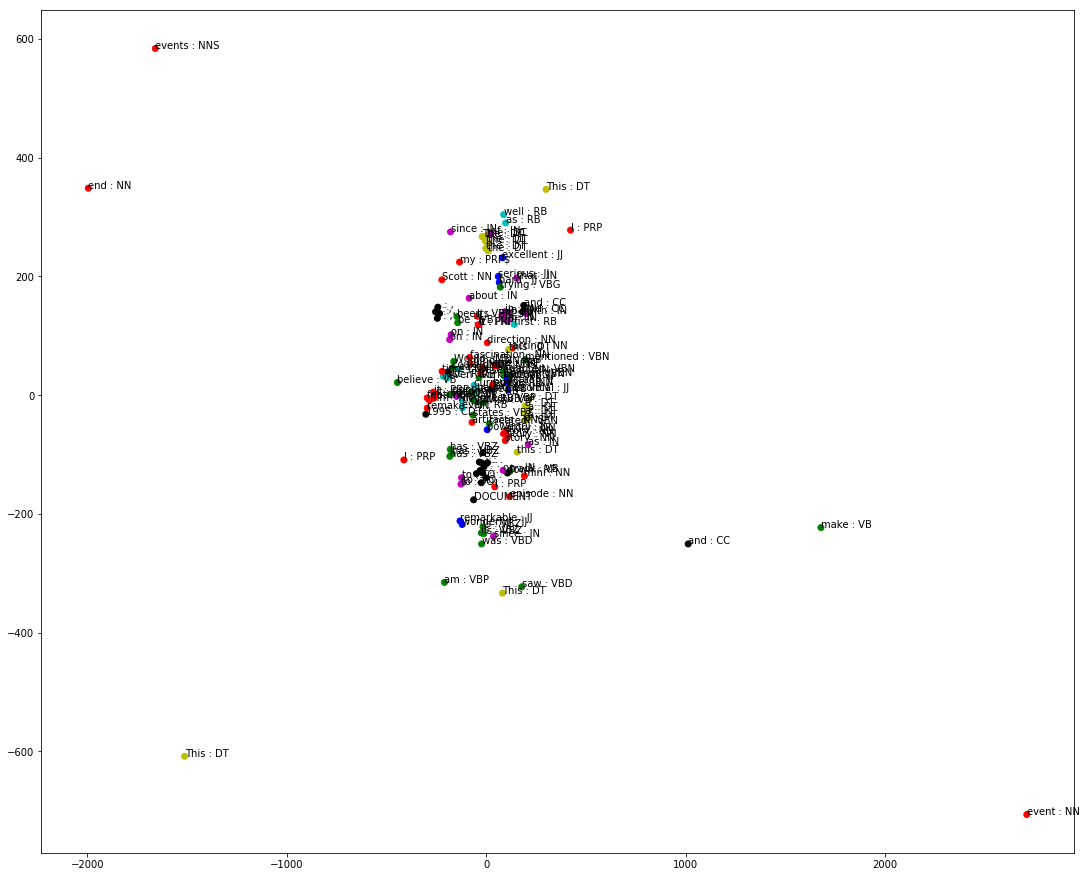

In [113]:
# PLOT SOME DOCUMENT WORD VECTORS AGAINST DOC VECTOR
plot_words_in_document(labelled_docs[0], doc2vec_model)


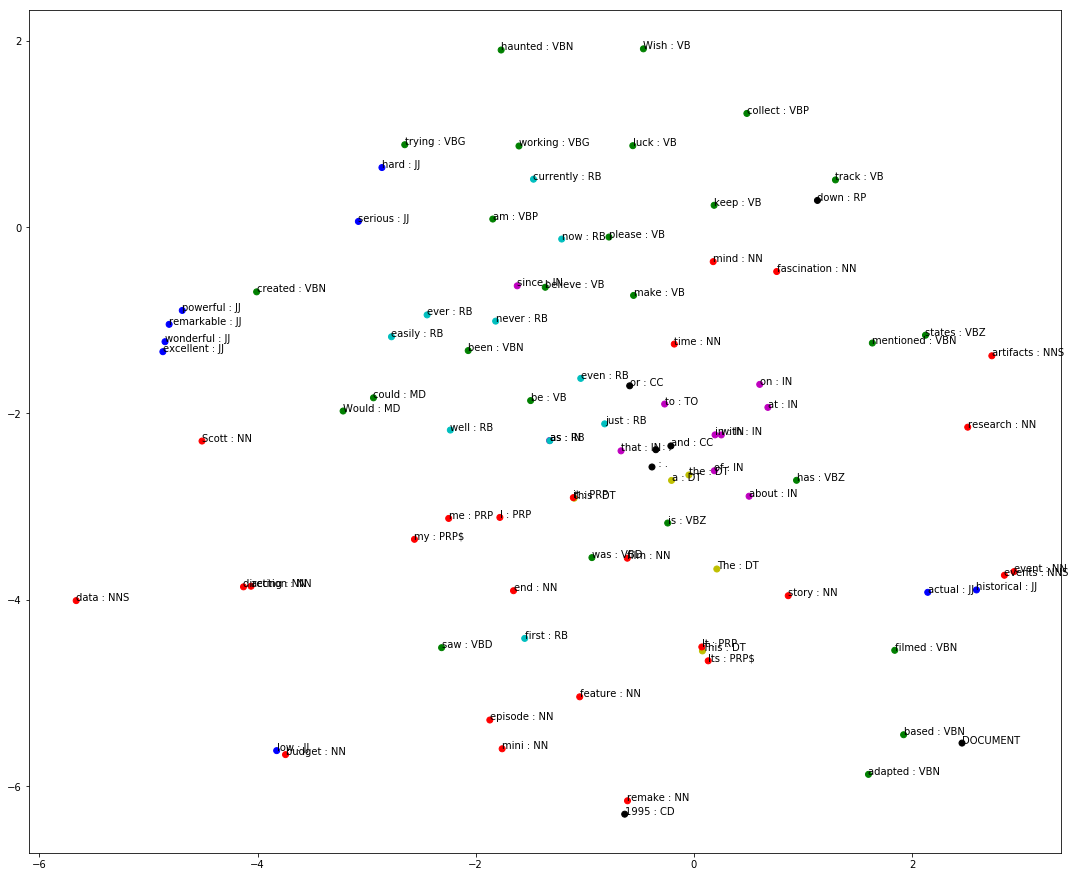

In [61]:
plot_words_in_document(labelled_docs[0], doc2vec_model)


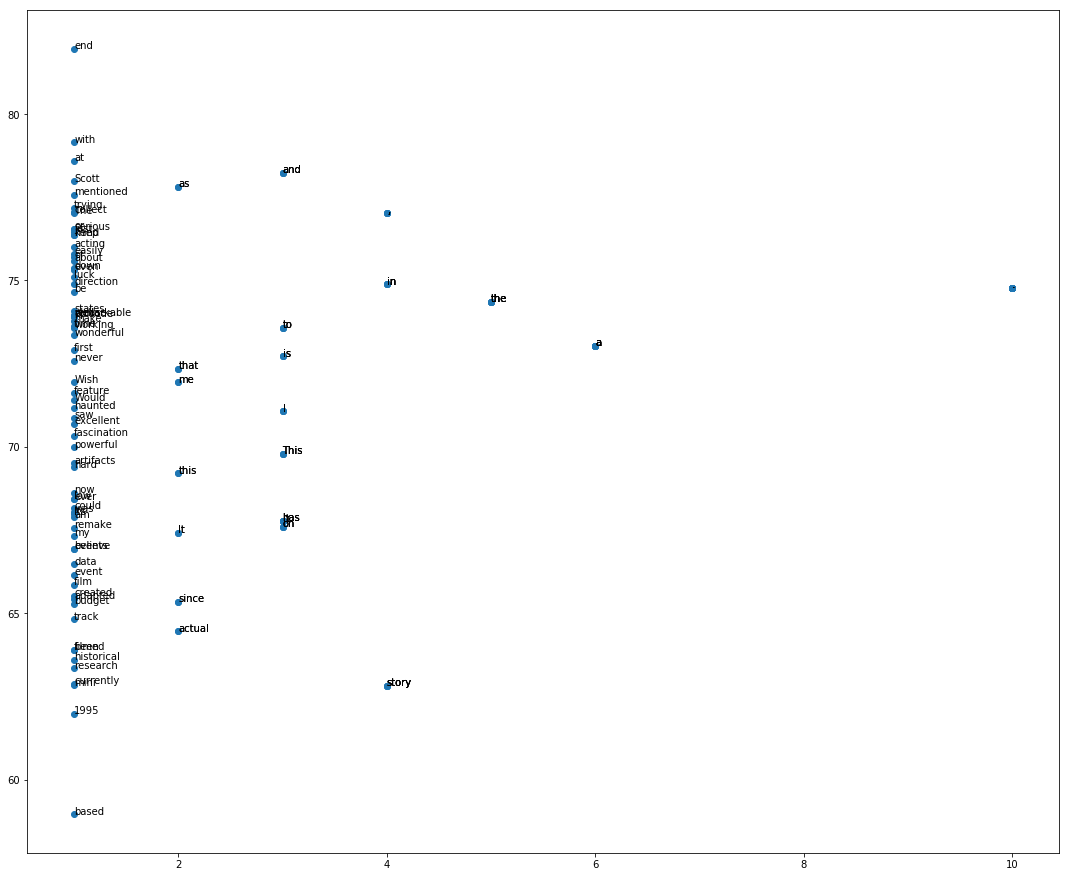

In [42]:
# FIND FREQUENCY VS DISTANCE
def plot_words_in_document(labelled_document, doc2vec_model):
    # Find word frequencies
    word_counts = dict()
    
    # Find word vectors
    words = []
    tags = []
    word_vectors = []
    for word, tag in labelled_document:
        try:
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1
            vector = doc2vec_model.wv.get_vector(word)
            words.append(word)
            word_vectors.append(vector)
            tags.append(tag)
        except:
            pass
    
    # Find doc vectors
    doc_words = [word for (word, label) in labelled_docs[0]]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    
    # Print angles
    angles_to_doc_vector = [(math.degrees(angle_between(word_vector, doc_vector)), word)
                            for word, word_vector 
                            in zip(words, word_vectors)]
    angles_to_doc_vector.sort()
#     print(angles_to_doc_vector)
#     print(max(angles_to_doc_vector))
#     print(min(angles_to_doc_vector))
    
    # Plot frequency vs angle
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    xs = [word_counts[value[1]] for value in angles_to_doc_vector]
    ys = [value[0] for value in angles_to_doc_vector]
    ax.scatter(xs, ys)
    for x, y, label in zip(xs, ys, [value[1] for value in angles_to_doc_vector]):
        ax.annotate(label, (x, y))
    plt.show()
    
plot_words_in_document(labelled_docs[0], doc2vec_model)

In [216]:
def plot_words_vs_min_frequency(labelled_doc_list, show_labels=True):
    # Calculate word frequencies
    word_count = dict()
    word_angle = dict()
    for doc in labelled_doc_list:
        for word, tag in doc:
            if (word, tag) not in word_count:
                word_count[(word, tag)] = 0 
                word_angle[(word, tag)] = None
            word_count[(word, tag)] += 1
      
    # Get min angles
    for doc in labelled_doc_list:
        update_word_doc_min_angles(doc, doc2vec_model, word_angle)
#     print(word_dict)
    
    # Plot word frequency vs angle with doc vector.
    xs = []
    ys = []
    labels = []
    colours = []
    for word_tag, freq in word_count.items():
        angle = word_angle[word_tag]
        xs.append(freq)
        ys.append(angle)
        labels.append(word_tag[0])
        colours.append(tag_to_colour(word_tag[1]))
    
#     print("xs")
#     print(xs)
#     print("ys")
#     print(ys)
#     print("labels")
#     print(labels)
#     print("colours")
#     print(colours)
    
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    for x, y, label, colour in zip(xs, ys, labels, colours):
        if y is not None:
            ax.scatter(x, y, c=colour)
            if show_labels:
                ax.annotate(label, (x, y))
    ax.set_xscale('log')
    plt.xlim(0.9,1000)
    plt.show()
    return xs, ys, labels, colours

    
def update_word_doc_min_angles(doc, doc2vec_model, word_angle):
    # Find doc vector
    doc_words = [actual_word for actual_word, tag in doc]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    
    # Find word vectors - doc vector angle
    for word, tag in doc:
        try:
            vector = doc2vec_model.wv.get_vector(word)
            angle = math.degrees(angle_between(vector, doc_vector))
            if word_angle[tag] == None:
                word_angle[(word, tag)] = angle
            word_angle[(word, tag)] = min(angle, word_angle[(word, tag)])
        except:
            pass


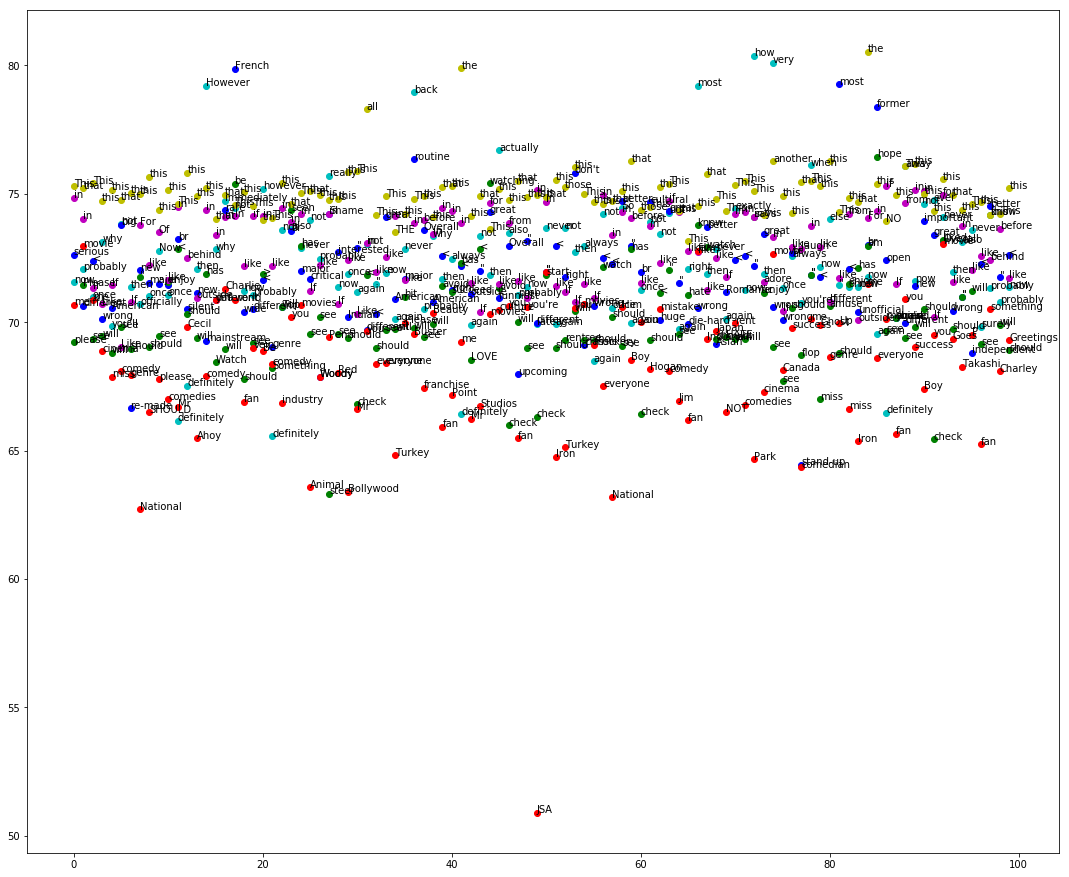

In [259]:
def plot_doc_against_angle_min(docs, show_labels=True):
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")

    for doc_number, labelled_doc in enumerate(docs):
        # Find doc vector
        doc_words = [actual_word for actual_word, tag in doc]
        doc_vector = doc2vec_model.infer_vector(doc_words)
        
        # Get smallest angle per tag
        tag_dict = dict()
        for word, tag in labelled_doc:
            try:
                vector = doc2vec_model.wv.get_vector(word)
                angle = math.degrees(angle_between(vector, doc_vector))
                colour = tag_to_colour(tag)
                if colour not in tag_dict:
                    tag_dict[colour] = []
                tag_dict[colour].append((angle, word))
            except:
                pass
            
        for colour, words in tag_dict.items():
            if colour != "k":
                min_word = min(words)
                ax.scatter(doc_number, min_word[0], c=colour)
                if show_labels:
                    ax.annotate(min_word[1], (doc_number, min_word[0]))

    plt.show() 

plot_doc_against_angle_min(labelled_docs[:100], show_labels=True)

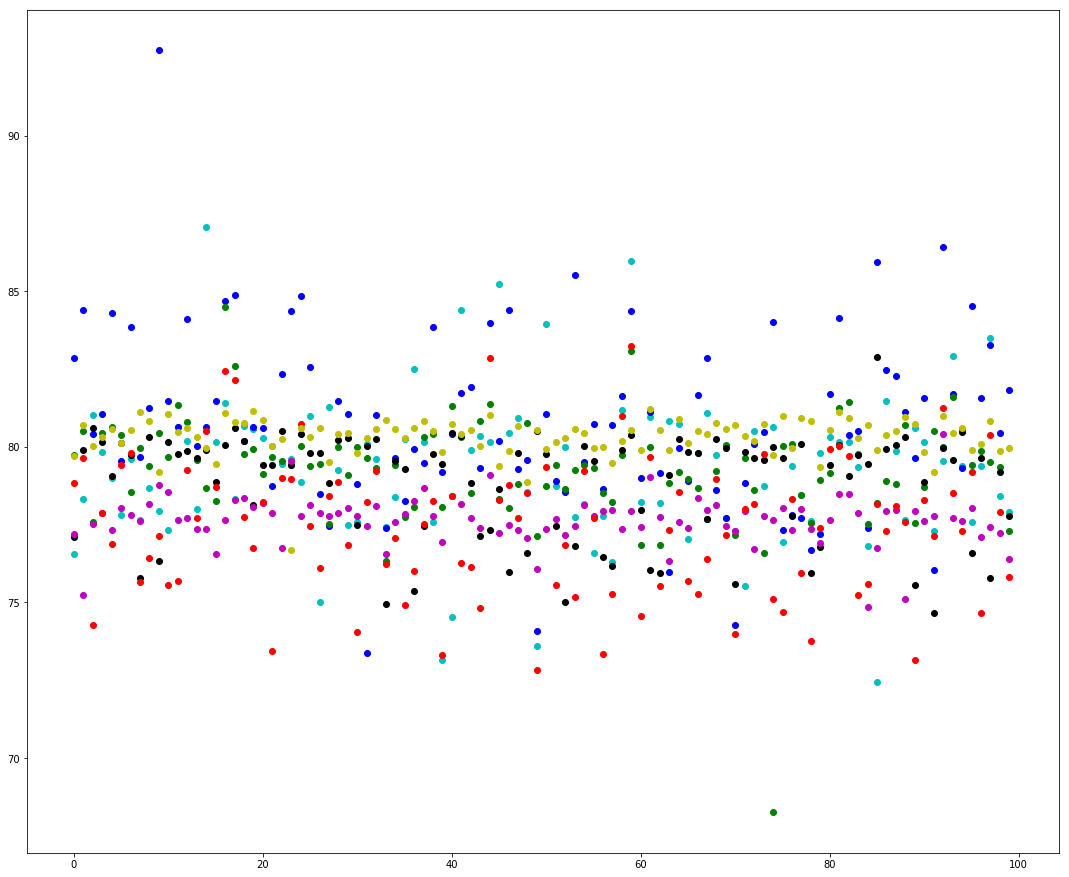

In [256]:
def plot_doc_against_angle(docs, show_labels=True):
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")

    for doc_number, labelled_doc in enumerate(docs):
        # Find doc vector
        doc_words = [actual_word for actual_word, tag in doc]
        doc_vector = doc2vec_model.infer_vector(doc_words)
        
        # Get smallest angle per tag
        tag_dict = dict()
        for word, tag in labelled_doc:
            try:
                vector = doc2vec_model.wv.get_vector(word)
                angle = math.degrees(angle_between(vector, doc_vector))
                colour = tag_to_colour(tag)
                if colour not in tag_dict:
                    tag_dict[colour] = []
                tag_dict[colour].append((angle, word))
            except:
                pass
            
        for colour, words in tag_dict.items():
            words.sort()
            min_word = words[int(math.ceil(len(words)/2))]
            ax.scatter(doc_number, min_word[0], c=colour)
            if show_labels:
                ax.annotate(min_word[1], (doc_number, min_word[0]))

    plt.show() 

plot_doc_against_angle(labelled_docs[:100], show_labels=False)

In [239]:
def plot_selectively(xs, ys, labels, colours, max_colour=50, sorted=True, show_labels=True):   
    points_sorted = [(y, x, label, colour) for x, y, label, colour in zip(xs, ys, labels, colours)]
    if sorted:
        points_sorted.sort()
    else:
        random.shuffle(points_sorted)

    common_words = dict()
    for y, x, label, colour in points_sorted:
        if y is None:
            continue
        if colour not in common_words :
            common_words[colour] = [(x, y, label)]
        else:
            if len(common_words[colour]) < max_colour:
                common_words[colour].append((x, y, label))
    
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    for colour, points in common_words.items():
        if colour != "k"
            for point in points:
                x, y, label = point
                if y is not None:
                    ax.scatter(x, y, c=colour)
                    if show_labels:
                        ax.annotate(label, (x, y))
    ax.set_xscale('log')
    plt.xlim(0.5,100)
    plt.show()

plot_selectively(xs, ys, labels, colours, max_colour=50, sorted=True, show_labels=False)

SyntaxError: invalid syntax (<ipython-input-239-9602271892d2>, line 22)

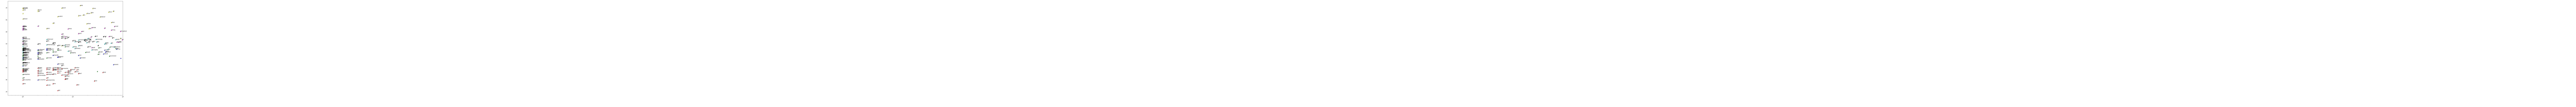

In [233]:
plot_selectively(xs, ys, labels, colours, max_colour=50, sorted=True, show_labels=True)

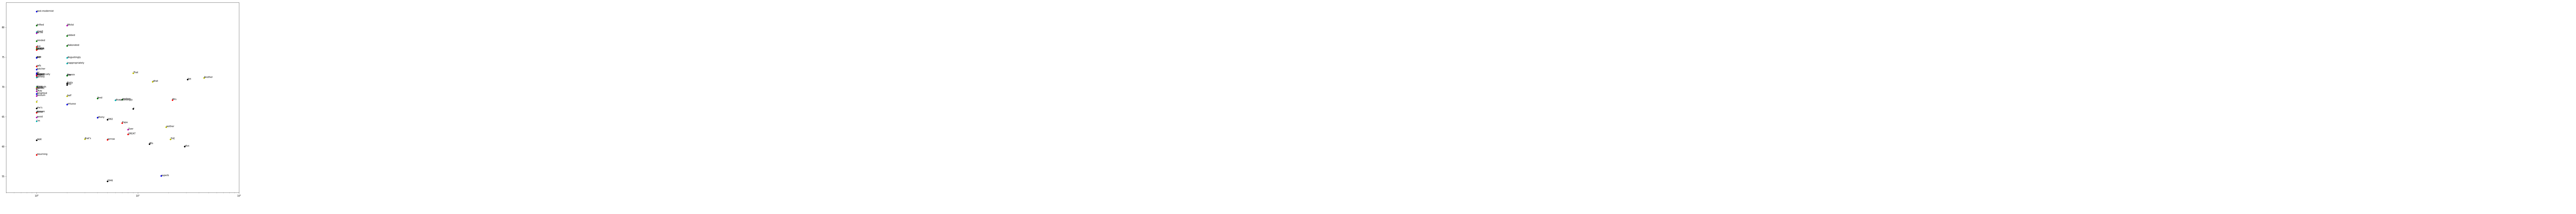

In [243]:

plot_selectively(xs, ys, labels, colours, max_colour=10, sorted=False, show_labels=True)

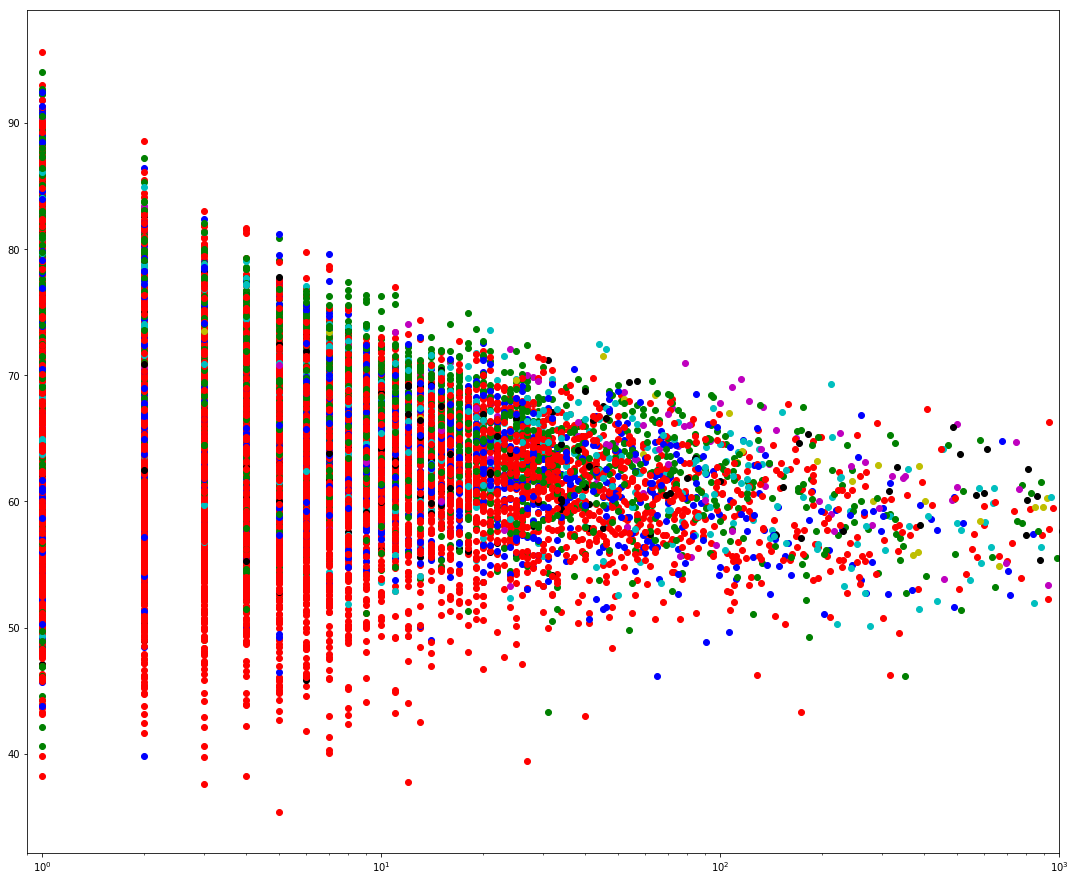

In [217]:
xs, ys, labels, colours = plot_words_vs_min_frequency(labelled_docs[:2000], show_labels=False)

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


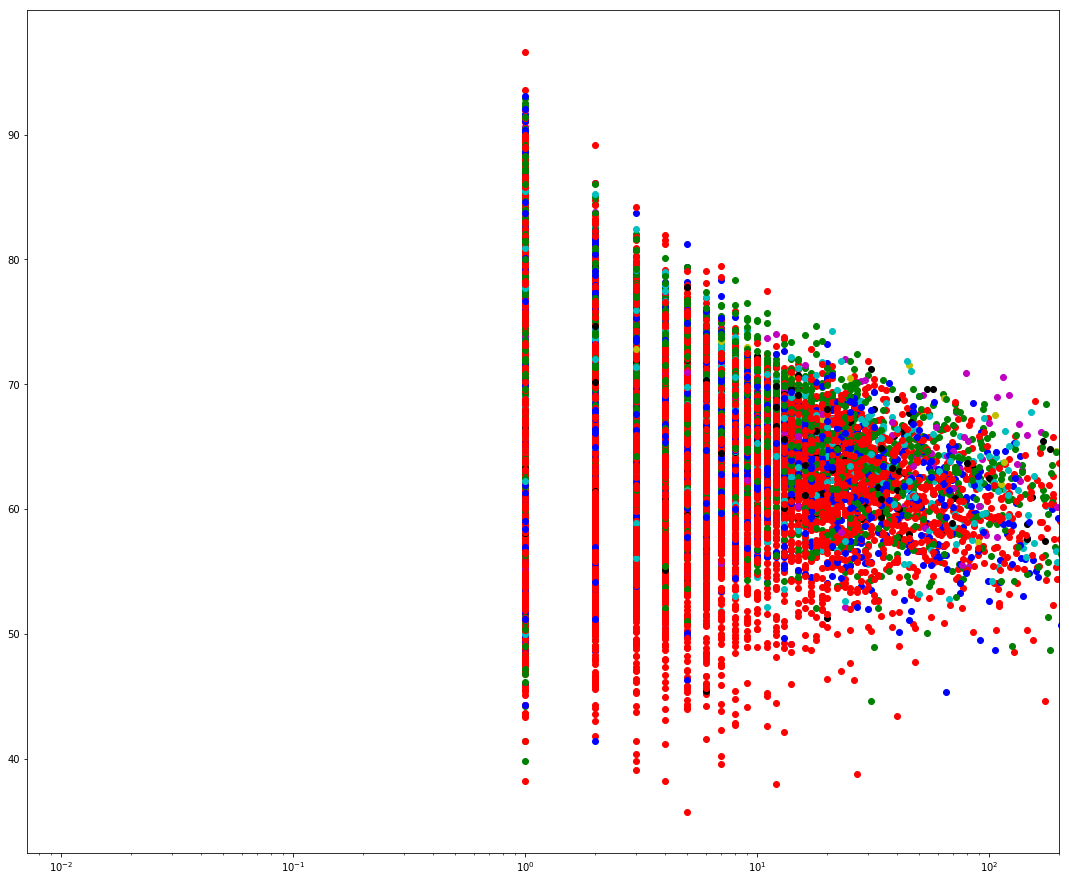

In [214]:
xs, ys, labels, colours = plot_words_vs_min_frequency(labelled_docs[:2000], show_labels=False)

In [198]:
def tag_to_colour(tag):
    if tag.startswith("NN") or tag.startswith("PRP") or tag.startswith("WP"):
        # NOUN
        return "r"
    elif tag.startswith("VB") or tag.startswith("MD"):
        # VERB
        return "g"
    elif tag.startswith("JJ"):
        # ADJECTIVE
        return "b"
    elif tag.startswith("RB") or tag.startswith("WRB"):
        # ADVERB
        return "c"
    elif tag.startswith("DT") or tag.startswith("EX") or tag.startswith("WDT"):
        # DETERMINER
        return "y"
    elif tag.startswith("IN") or tag.startswith("TO"):
        # PREPOSITION
        return "m"
    else:
        # OTHER
        return "k"

KeyboardInterrupt: 

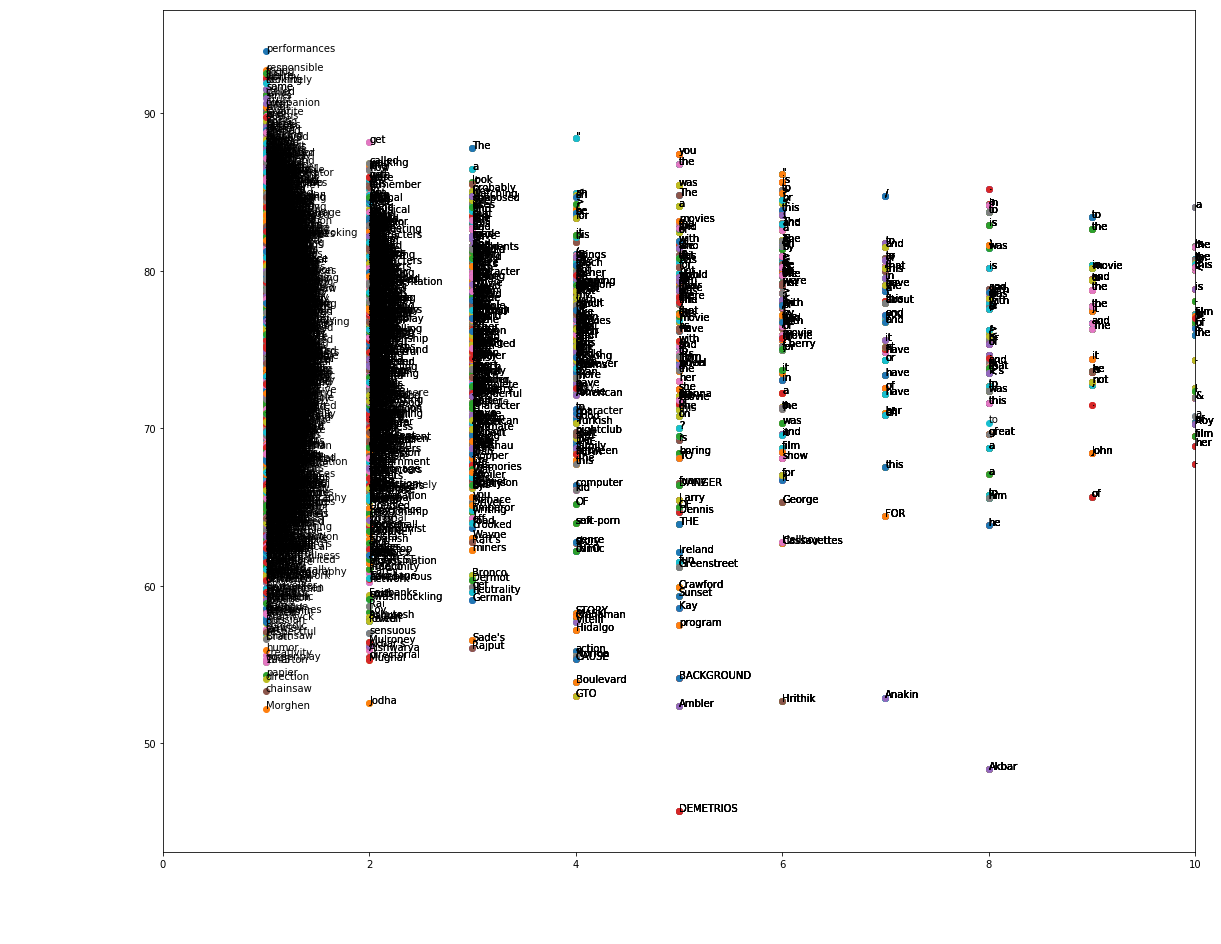

In [66]:
def plot_words_vs_frequency(labelled_doc_list):
    # Calculate word frequencies
    word_counts = dict()
    for doc in labelled_doc_list:
        for word, tag in doc:
            if word not in word_counts:
                word_counts[(word, tag)] = 0
            word_counts[(word, tag)] += 1
    
    # Plot word frequency vs angle with doc vector.
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    plt.xlim(0,10)
    plotted_words = set()
    for doc in labelled_doc_list:
        plot_word_doc_angles(doc, doc2vec_model, ax, word_counts, plotted_words)
    plt.show()

def plot_word_doc_angles(doc, doc2vec_model, ax, word_counts, plotted_words):
    # Find word vectors
    words = []
    for word, tag in doc:
        try:
            vector = doc2vec_model.wv.get_vector(word)
            words.append((word, vector, tag))
        except:
            pass
    
    # Find doc vector
    doc_words = [actual_word for actual_word, tag in doc]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    
    # Calculate difference in angle
    angles_to_doc_vector = [(math.degrees(angle_between(vector, doc_vector)), word)
                            for word, vector, _ in words]

    # Plot
    xs = [word_counts[word] for angle, word in angles_to_doc_vector] # Frequency
    ys = [angle for angle, word in angles_to_doc_vector] # Angle
    labels = [word for angle, word in angles_to_doc_vector]
    for x, y, label in zip(xs, ys, labels):
#         if label not in plotted_words:
        ax.scatter(x,y)
        plotted_words.add(label)
        ax.annotate(label, (x, y))

plot_words_vs_frequency(labelled_docs[:50])

In [68]:
def plot_words_vs_frequency(labelled_doc_list):
    # Calculate word frequencies
    word_counts = calc_word_frequencies()
    
    # Plot word frequency vs angle with doc vector.
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    plt.xlim(0,10)
    plotted_words = set()
    for doc in labelled_doc_list:
        plot_word_doc_angles(doc, doc2vec_model, ax, word_counts, plotted_words)
    plt.show()
    
def calc_word_frequencies():
    word_counts = dict()
    for doc in labelled_docs:
        for word, tag in doc:
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1
    return word_counts

def plot_word_doc_angles(doc, doc2vec_model, ax, word_counts, plotted_words):
    # Find word vectors
    words = []
    for word, tag in doc:
        try:
            vector = doc2vec_model.wv.get_vector(word)
            words.append((word, vector, tag))
        except:
            pass
    
    # Find doc vector
    doc_words = [actual_word for actual_word, tag in doc]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    
    # Calculate difference in angle
    angles_to_doc_vector = [(math.degrees(angle_between(vector, doc_vector)), word)
                            for word, vector, _ in words]

    # Plot
    xs = [word_counts[word] for angle, word in angles_to_doc_vector] # Frequency
    ys = [angle for angle, word in angles_to_doc_vector] # Angle
    labels = [word for angle, word in angles_to_doc_vector]
    for x, y, label in zip(xs, ys, labels):
#         if label not in plotted_words:
        ax.scatter(x,y)
        plotted_words.add(label)
        ax.annotate(label, (x, y))

plot_words_vs_frequency(labelled_docs[:50])

ValueError: Image size of 582403x953 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1332x1116 with 1 Axes>

### Execution

In [11]:
# WRITE POS TAGS DOCS TO FILE
labelled_docs = write_embeddings_training_set_pos_tag(ACL_FOLDER_PATHS)

In [20]:
# RETRIEVE DOC2VEC MODEL
doc2vec_file = get_tmpfile("my_doc2vec_model")
doc2vec_model = Doc2Vec.load(doc2vec_file)

In [21]:
doc2vec_model

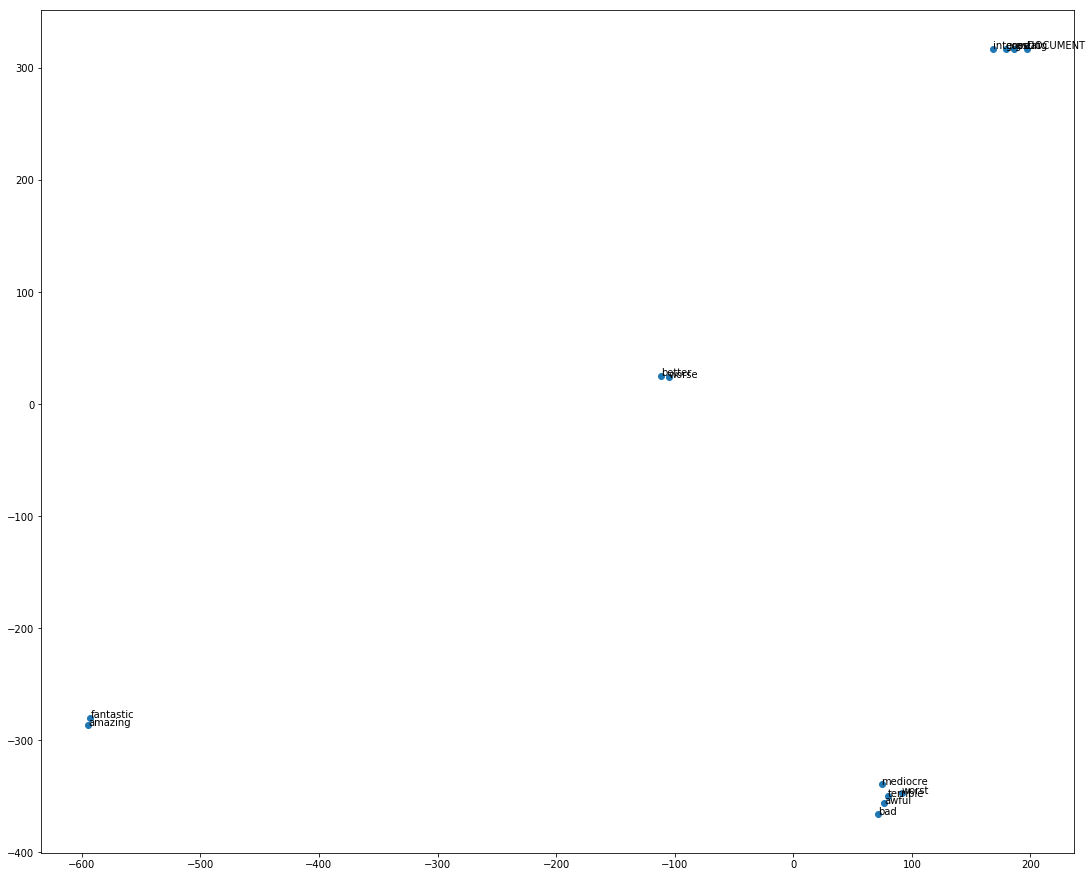

In [94]:
def create_2d_plot(vectors, labels):
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    xs = [vector[0] for vector in vectors]
    ys = [vector[1] for vector in vectors]
    ax.scatter(xs, ys)
    for x, y, label in zip(xs, ys, labels):
        ax.annotate(label, (x, y))
    plt.show()

words = ["fantastic", "great", "amazing", "bad", "awful", "terrible", "worse", "worst", "better", "good", "mediocre", "interesting"]
# words = [word
#          for doc in labelled_docs[:200]
#          for word, _ in doc]
# for word in words:
#     try:
#         doc2vec_model.wv.get_vector(word)
#     except:
#         print("Failed {}".format(word))


vectors = [doc2vec_model.wv.get_vector(word) for word in words]
doc_vector = doc2vec_model.infer_vector(labelled_docs[0][0])
vectors.append(doc_vector)
words.append("DOCUMENT")
vectors_reduced = TSNE(n_components=2, perplexity=1).fit_transform(vectors)
create_2d_plot(vectors_reduced, words)


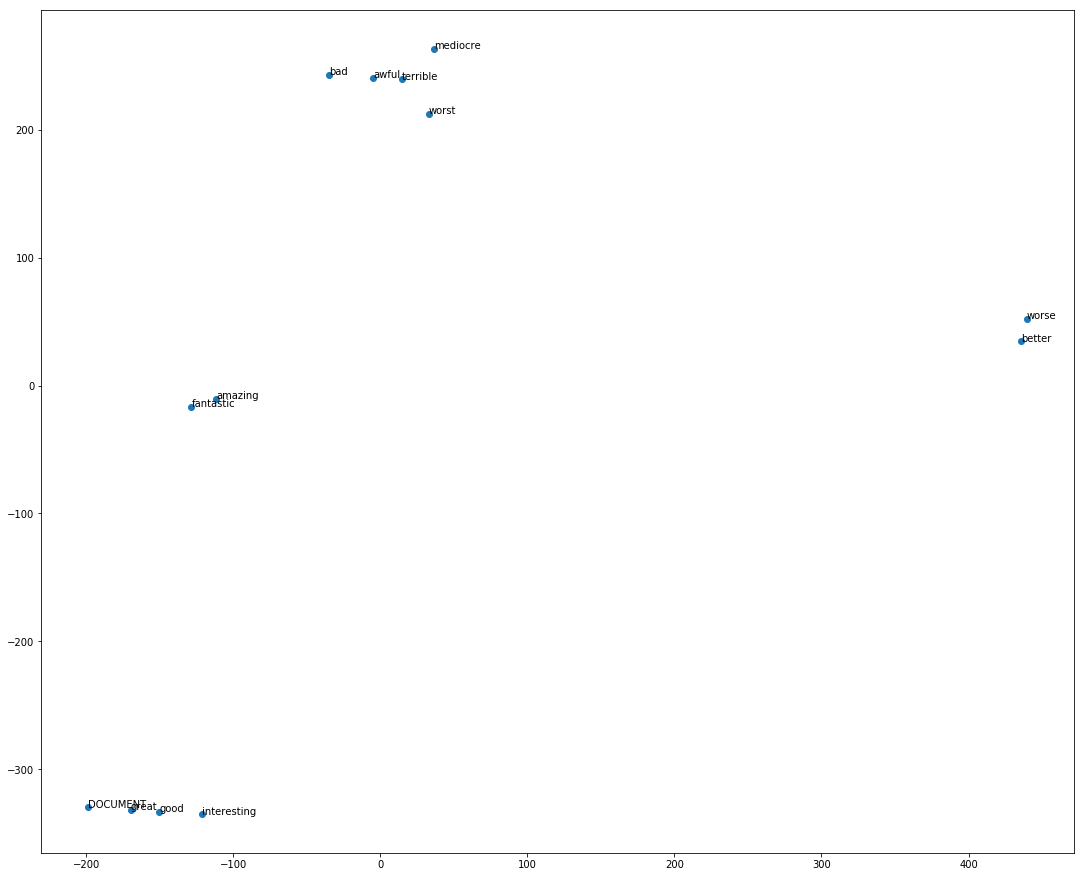

In [109]:
words = ["fantastic", "great", "amazing", "bad", "awful", "terrible", "worse", "worst", "better", "good", "mediocre", "interesting"]
vectors = [doc2vec_model.wv.get_vector(word) for word in words]
doc_vector = doc2vec_model.infer_vector(labelled_docs[0][0])
vectors.append(doc_vector)
words.append("DOCUMENT")
vectors_reduced = TSNE(n_components=2, perplexity=1).fit_transform(vectors)
create_2d_plot(vectors_reduced, words)


In [104]:
for word, vector in zip(words[:-1], vectors[:-1]):
    print("{} : {}".format(word, (math.degrees(angle_between(vector, doc_vector)))))

print("\n\n")
for word, vector in zip(words[:-1], vectors[:-1]):
    print("{} : {}".format(word, np.linalg.norm(vector-doc_vector)))
    
print("\n\n")
for word, vector in zip(words[:-1], vectors_reduced[:-1]):
    print("{} : {}".format(word, np.linalg.norm(vector-vectors_reduced[-1])))
    
vectors_reduced_99 = TSNE(n_components=3, perplexity=1).fit_transform(vectors)
print("\n\n")
for word, vector in zip(words[:-1], vectors_reduced_99[:-1]):
    print("{} : {}".format(word, np.linalg.norm(vector-vectors_reduced_99[-1])))

fantastic : 60.5129488763
great : 56.6377556733
amazing : 60.3147572772
bad : 54.9126343041
awful : 55.682123416
terrible : 53.0224272626
worse : 61.1355957512
worst : 57.6538248596
better : 63.2740255275
good : 54.6843044953
mediocre : 57.7882839636
interesting : 57.3905005765



fantastic : 1.67912328243
great : 1.51676428318
amazing : 1.77989566326
bad : 1.67494666576
awful : 1.71304428577
terrible : 1.61176776886
worse : 1.93410098553
worst : 2.10895895958
better : 1.77559888363
good : 1.55194306374
mediocre : 1.70154440403
interesting : 1.61917424202



fantastic : 989.89642334
great : 10.7053670883
amazing : 995.128601074
bad : 694.427062988
awful : 683.874755859
terrible : 676.758239746
worse : 420.873168945
worst : 672.583984375
better : 424.377868652
good : 17.8358039856
mediocre : 667.210021973
interesting : 28.5158157349



fantastic : 641.181762695
great : 2487.74487305
amazing : 501.295074463
bad : 483.447723389
awful : 697.172180176
terrible : 321.7706604
worse : 344.4683